# Objectif du projet
Ce projet vise à prédire la capacité des clients à rembourser un prêt en utilisant des modèles de Machine Learning.

## Workflow du Notebook
- Importation des librairies
- Définition des fonctions utiles
- Analyse exploratoire (EDA)
- Préparation et transformation des données
- Entraînement de modèles : RandomForest, MLP, XGBoost
- Évaluation avec seuil optimisé selon le **coût métier**

# Importation des bibliothèques

In [6]:
# Système & fichiers
import os
import time
import random
import pickle
import json
import joblib
from pprint import pprint
import shap
#!pip install shap

# Colab
from google.colab import drive

# NumPy, Pandas
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix, plot_learning_curves, plot_decision_regions

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from tensorflow.keras.metrics import AUC, Recall, Precision
import joblib
import pickle

# Gestion des classes déséquilibrées
from imblearn.over_sampling import SMOTE
from collections import Counter

# Deep Learning (Keras / TensorFlow)
import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers


In [8]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CreditScoring')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/CreditScoring'

# Définition des fonctions

##### Fonctions d'analyse

In [9]:
def data_overview(df):
    print("\nInformation of the DataFrame:")
    print(df.info())

    print("\nShape of the DataFrame:", df.shape)
    display(df.head())

    print("\nDescription of the DataFrame:")
    display(df.describe())

    print("\nData Types of each column:")
    print(df.dtypes)

    # print("\nColumns of the DataFrame:")
    # pprint(df.columns.tolist())


def visualize_target_distribution(df, col):
    if col != 'TARGET':
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=col, hue='TARGET', data=df)
        plt.title(f'Distribution of TARGET by {col}')

        # Ajouter les valeurs sur chaque barre
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black')

        plt.show()


def null_values_summary(df, percent=0):
    """
    Résume les valeurs manquantes dans un DataFrame.

    Parameters:
    df (pd.DataFrame): Le DataFrame à analyser.
    percent (float): Seuil minimum (%) de valeurs nulles pour afficher une colonne.
                     Par exemple, percent=20 affichera uniquement les colonnes
                     ayant au moins 20 % de valeurs manquantes.

    Returns:
    pd.DataFrame: Tableau résumant le total et le pourcentage de valeurs nulles,
                  trié par nombre total décroissant, et filtré selon le seuil.
    """
    total = df.isnull().sum()
    pct = (total / len(df)) * 100
    missing_data = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
    filtered_data = missing_data[(missing_data['Total'] != 0) & (missing_data['Percent'] >= percent)]
    return filtered_data.sort_values('Total', ascending=False)


def missing_values_by_row(df, threshold=0):
    """
    Analyse des valeurs manquantes par ligne.

    Parameters:
    df (pd.DataFrame): DataFrame à analyser.
    threshold (float): Seuil minimum (%) pour afficher les lignes concernées.

    Returns:
    pd.DataFrame: ID lignes + nombre et pourcentage de valeurs manquantes.
    """
    total_missing = df.isnull().sum(axis=1)
    pct_missing = (total_missing / df.shape[1]) * 100
    missing_df = pd.DataFrame({
        'Total_missing': total_missing,
        'Percent_missing': pct_missing
    })
    filtered = missing_df[(missing_df['Total_missing'] != 0) & (missing_df['Percent_missing'] >= threshold)]
    return filtered.sort_values('Total_missing', ascending=False)


def categorical_summary(df):
    """
    Retourne un DataFrame résumant les colonnes catégorielles et leur cardinalité.

    Parameters:
    df (pd.DataFrame): DataFrame contenant les données.

    Returns:
    pd.DataFrame: Colonnes catégorielles + nombre de modalités uniques.
    """
    cat_cols = df.select_dtypes(include='object').columns
    summary = pd.DataFrame({
        'Column': cat_cols,
        'Nb_modalités': [df[col].nunique() for col in cat_cols]
    })
    return summary.sort_values('Nb_modalités', ascending=False)


def plot_categorical_distributions(df, cols):
    """
    Affiche la distribution des colonnes catégorielles.

    Parameters:
    df (pd.DataFrame): DataFrame contenant les données.
    cols (list): Liste de colonnes catégorielles à visualiser.
    """
    for col in cols:
        plt.figure(figsize=(8,4))
        ax = sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(f'Distribution de {col}')
        plt.xticks(rotation=45)

        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9, color='black')
        plt.show()


def correlation_analysis(df, threshold=0.01):
    """
    Analyse les corrélations avec TARGET et entre variables.

    Parameters:
    df (pd.DataFrame): DataFrame contenant les données.
    threshold (float): Seuil de corrélation absolue à afficher.

    Returns:
    (pd.DataFrame, pd.DataFrame): Variables corrélées à TARGET et entre elles.
    """
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr()
    target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)
    strong_target_corr = target_corr[target_corr > threshold]

    corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
    corr_pairs = corr_pairs[corr_pairs < 1]

    strong_pairs = corr_pairs[corr_pairs > threshold]

    return strong_target_corr, strong_pairs


# def plot_correlation_matrix(df):
#     """
#     Affiche la matrice de corrélation.
#     """
#     numeric_df = df.select_dtypes(include=np.number)

#     plt.figure(figsize=(15,12))
#     corr = numeric_df.corr()
#     sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt='.2f')
#     plt.title('Matrice de corrélation')
#     plt.show()


##### fonctions de traitement

In [10]:
def impute_categorical_by_mode(df):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

def frequency_encode(df, cols):
    """
    Encode les colonnes catégorielles par leur fréquence relative.
    """
    for col in cols:
        freq = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq)
    return df

##### fonctions d'entrainement de modèle

In [11]:
def evaluate_cost_based_threshold(y_true, y_proba, C_FP=1000, C_FN=10000, model_name="Modèle"):
    """
    Calcule le coût métier en fonction du seuil de classification.
    Affiche la courbe coût vs seuil + classification report au seuil optimal.

    Parameters:
    - y_true : array-like, vraies étiquettes
    - y_proba : array-like, probabilités prédites (classe 1)
    - C_FP : int, coût d’un faux positif (refus bon client)
    - C_FN : int, coût d’un faux négatif (acceptation mauvais client)
    - model_name : str, nom du modèle (pour affichage)

    Returns:
    - optimal_threshold : float, seuil avec le coût minimal
    - final_cost : int, coût total associé
    """

    thresholds = np.arange(0.1, 0.91, 0.01)
    costs = []
    recalls = []
    accuracies = []

    for thresh in thresholds:
        y_pred = (y_proba > thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        FP = cm[0,1]
        FN = cm[1,0]

        cost = (FP * C_FP) + (FN * C_FN)
        costs.append(cost)

        recall_1 = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-6)
        accuracy = (cm[0,0] + cm[1,1]) / cm.sum()

        recalls.append(recall_1)
        accuracies.append(accuracy)

    # Seuil optimal
    optimal_index = np.argmin(costs)
    optimal_threshold = thresholds[optimal_index]
    final_cost = costs[optimal_index]

    print(f"✅ Seuil optimal pour {model_name} : {optimal_threshold:.2f}")
    print(f"💰 Coût métier minimal : {final_cost:,.0f} €")

    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, costs, label='Coût métier (€)', color='red')
    plt.axvline(optimal_threshold, linestyle='--', color='black', label=f'Seuil optimal = {optimal_threshold:.2f}')
    plt.xlabel("Seuil de classification")
    plt.ylabel("Coût total (€)")
    plt.title(f"{model_name} : Optimisation du seuil métier")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Évaluation finale au seuil optimal
    y_opt = (y_proba > optimal_threshold).astype(int)
    cm_opt = confusion_matrix(y_true, y_opt)
    # print("📉 Matrice de confusion (seuil optimisé) :\n", cm_opt)
    print("📊 Rapport de classification :")
    print(classification_report(y_true, y_opt))

    return optimal_threshold, final_cost


def courbes_validation(history):
    """
    Affiche les courbes d'apprentissage (loss et accuracy) pour l'entraînement et la validation.

    Parameters:
    - history : objet retourné par model.fit()
    """
    history_dict = history.history

    # Courbe de la loss
    plt.figure(figsize=(10, 5))
    plt.plot(history_dict['loss'], label='Training Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Courbe de l’accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Évolution de la Précision')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


#  Analyse exploratoire des données (EDA)

### Importation et visualtion du dataset

In [13]:
df = pd.read_csv('application_train.csv', sep=',')
#test = pd.read_csv('application_test.csv', sep=',')

In [14]:
data_overview(df)


Information of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

Shape of the DataFrame: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0



Description of the DataFrame:


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000



Data Types of each column:
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object


In [15]:
set(df.columns)

{'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

### Analyse des distributions

In [16]:
df['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


**highest borrower**

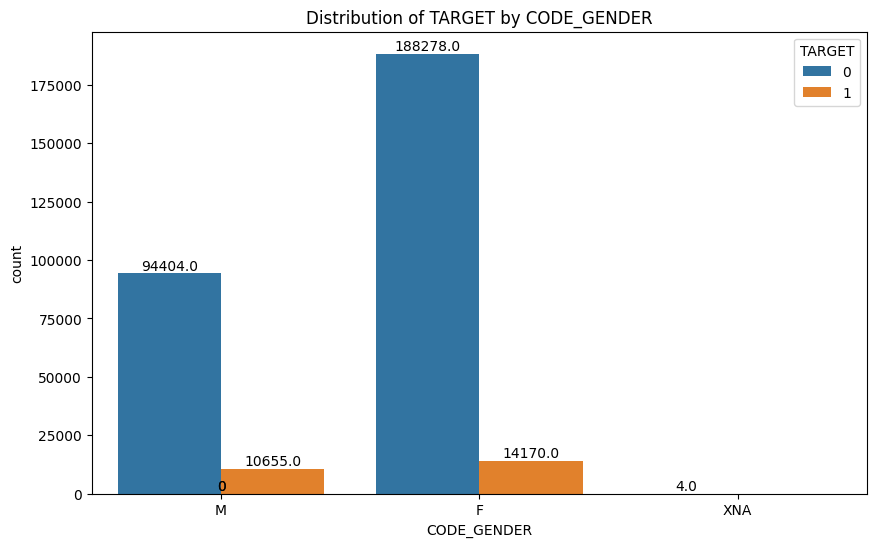

In [17]:
visualize_target_distribution(df,'CODE_GENDER' )

**Impact of children**

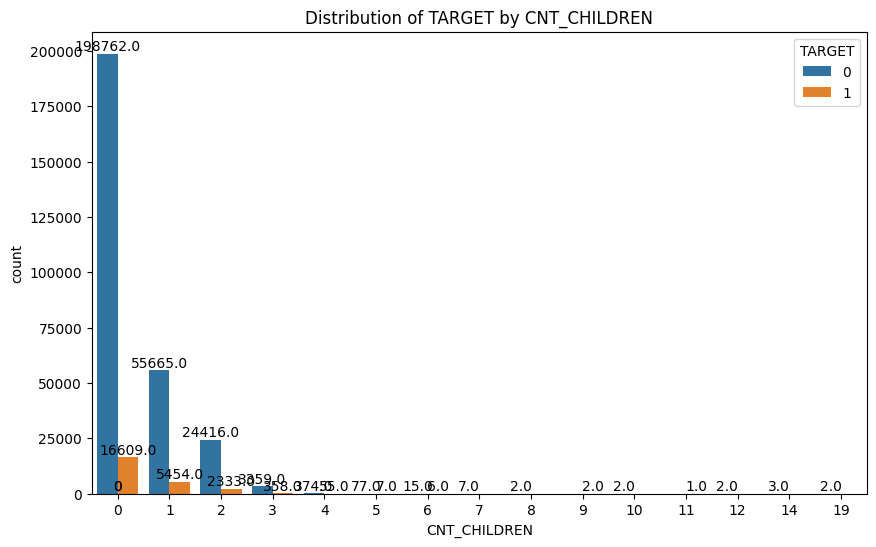

In [18]:
visualize_target_distribution(df,'CNT_CHILDREN' )

**Impact of owning a car**

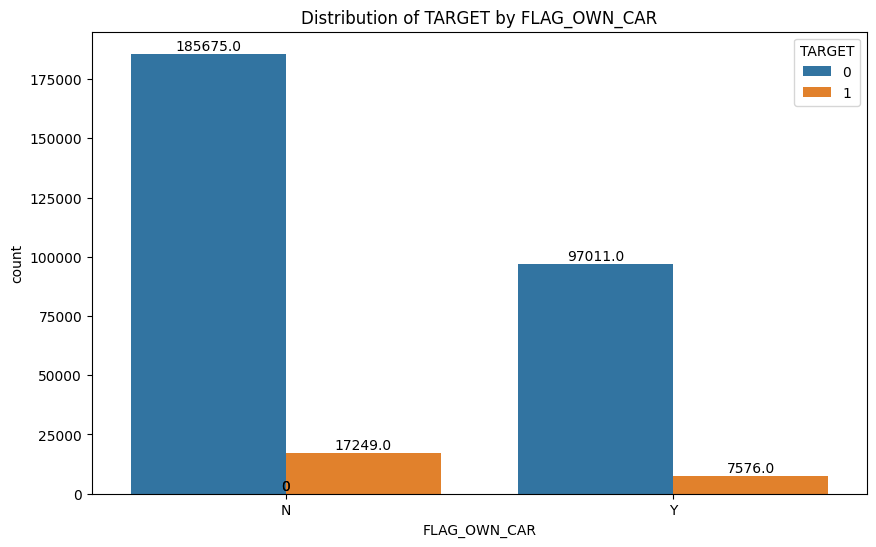

In [19]:
visualize_target_distribution(df,'FLAG_OWN_CAR' )
# fig, ax = plt.subplots(figsize=(10,7))
# sns.countplot(x='CODE_GENDER', hue='FLAG_OWN_CAR', data=train,palette="Set1")

**Impact of family status**

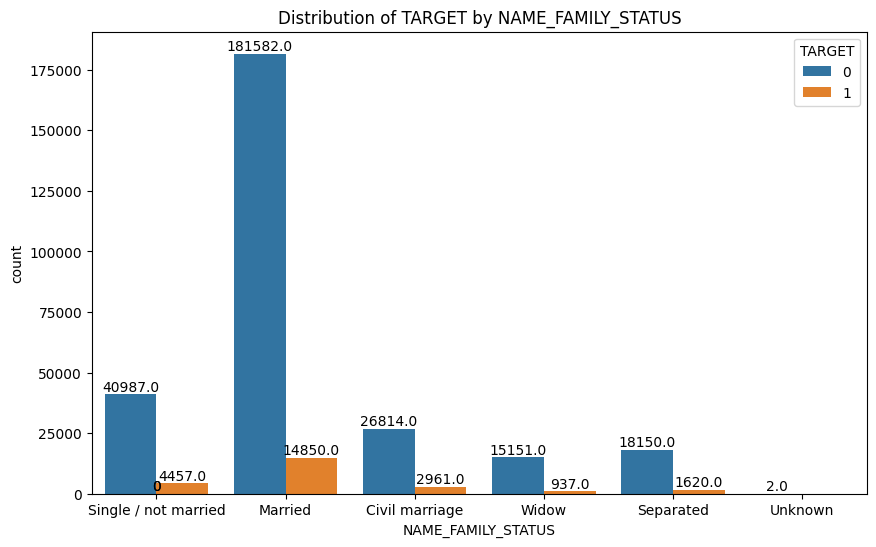

In [20]:
#train.columns  ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER']
visualize_target_distribution(df,'NAME_FAMILY_STATUS' )

### **Analyse des variables catégorielles**

In [21]:
categorical_summary(df)

,Column,Nb_modalités
11,ORGANIZATION_TYPE,58
9,OCCUPATION_TYPE,18
5,NAME_INCOME_TYPE,8
4,NAME_TYPE_SUITE,7
14,WALLSMATERIAL_MODE,7
10,WEEKDAY_APPR_PROCESS_START,7
7,NAME_FAMILY_STATUS,6
8,NAME_HOUSING_TYPE,6
6,NAME_EDUCATION_TYPE,5
12,FONDKAPREMONT_MODE,4


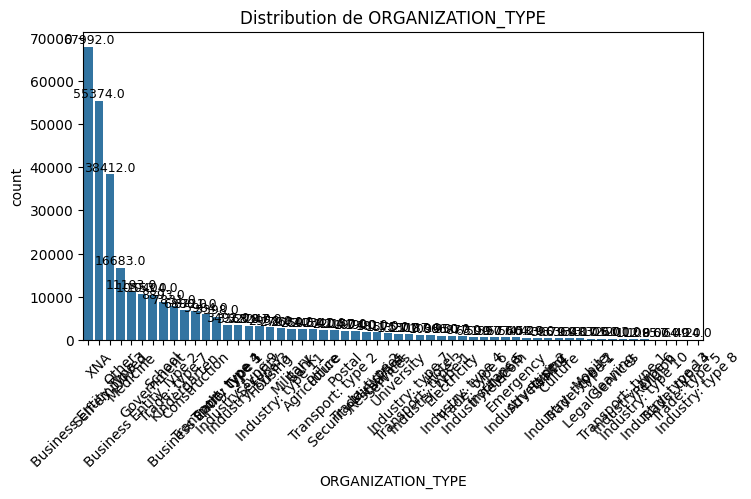

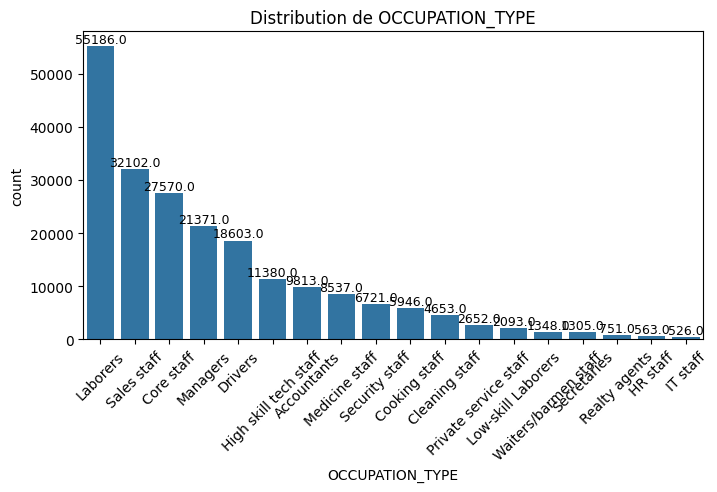

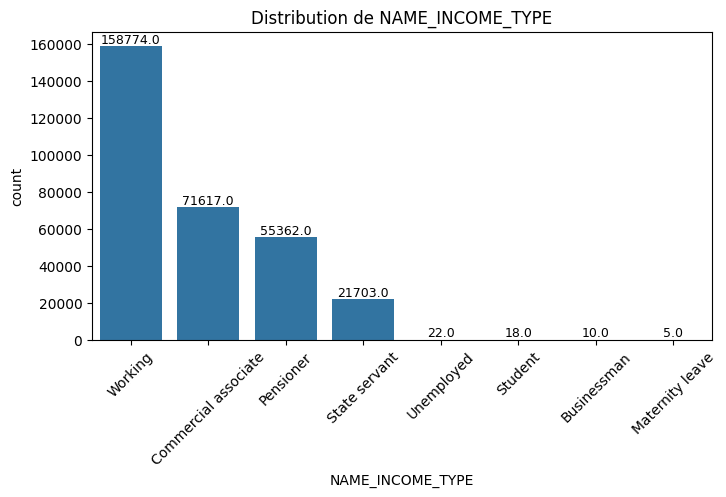

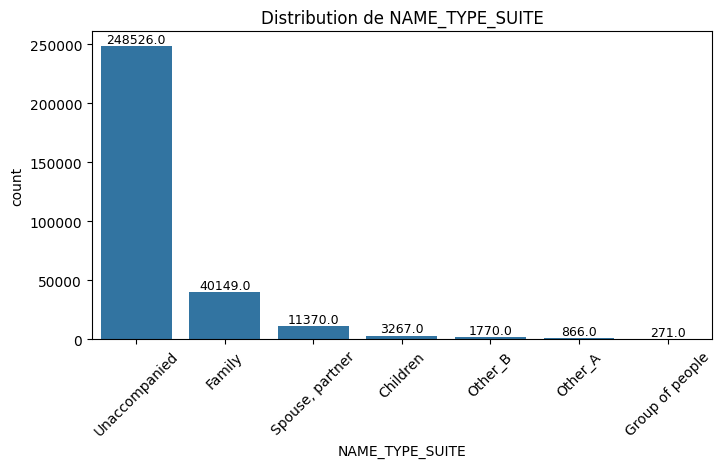

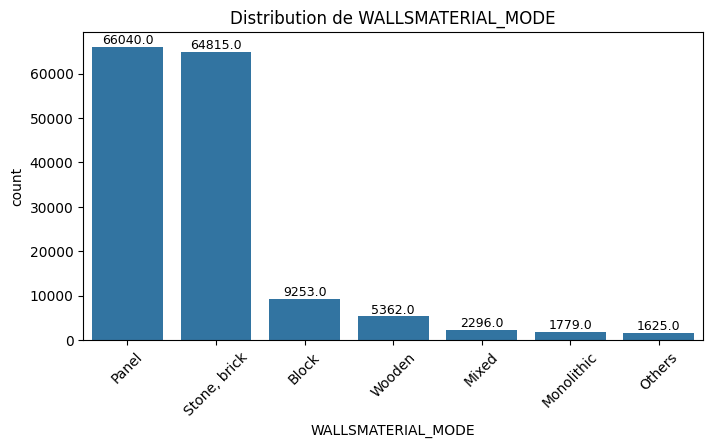

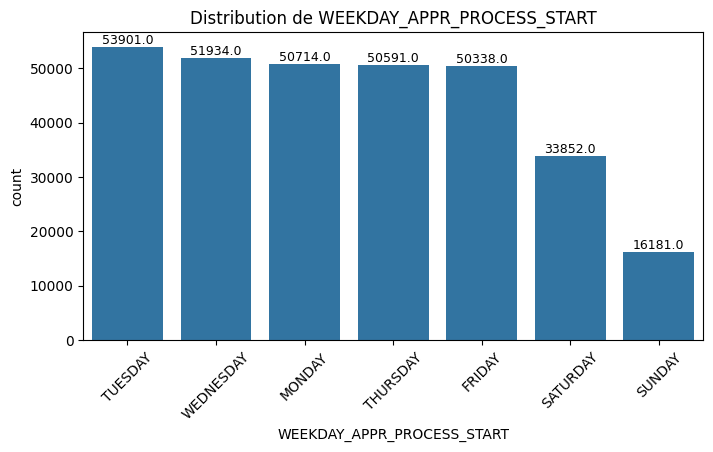

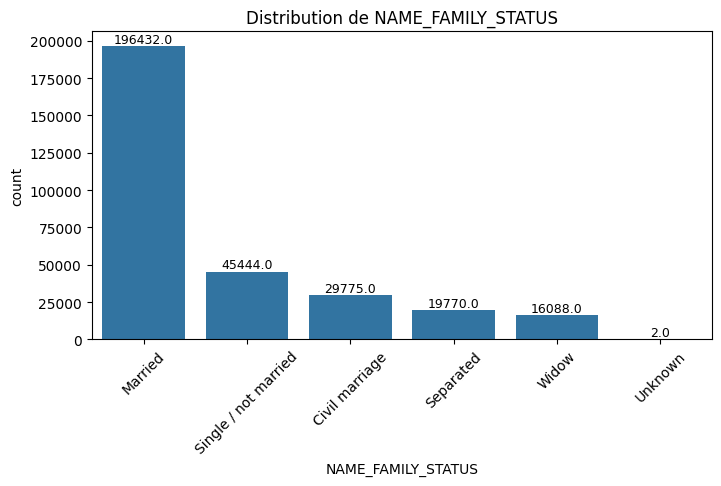

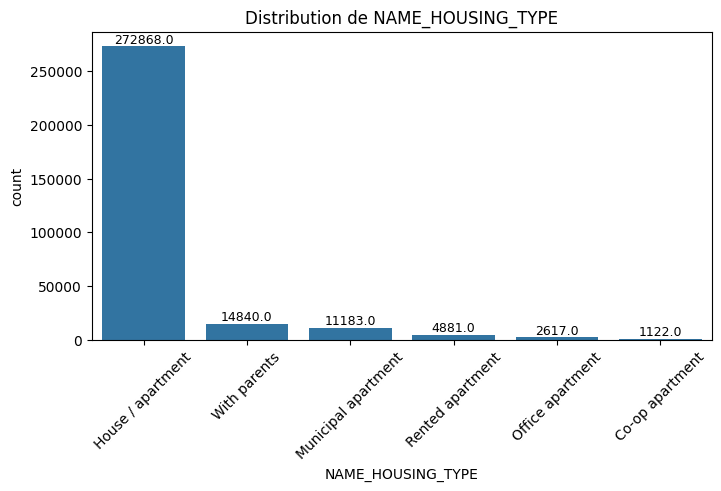

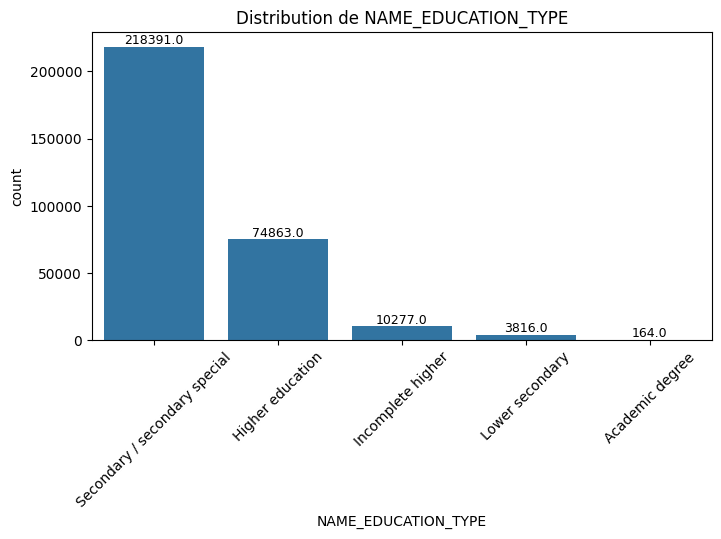

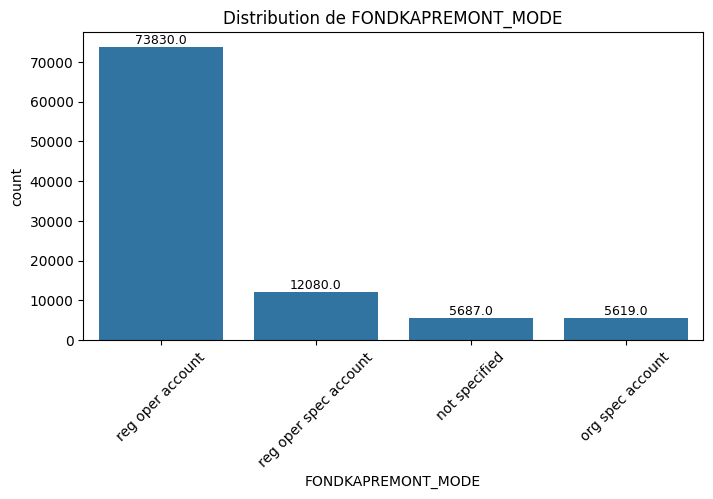

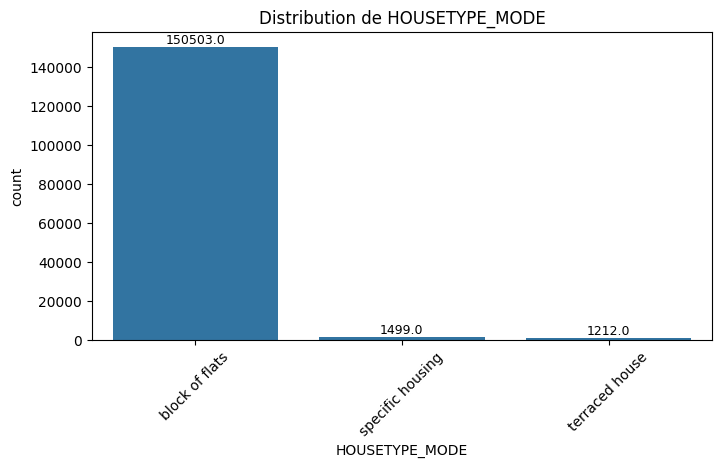

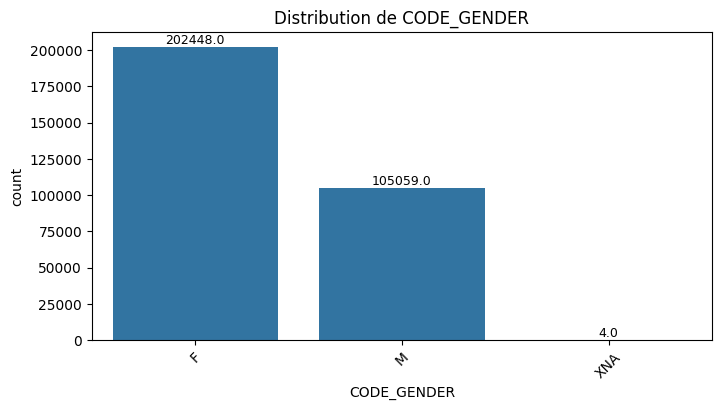

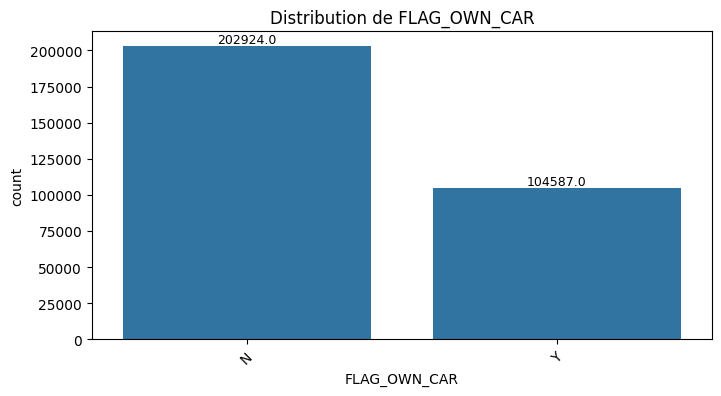

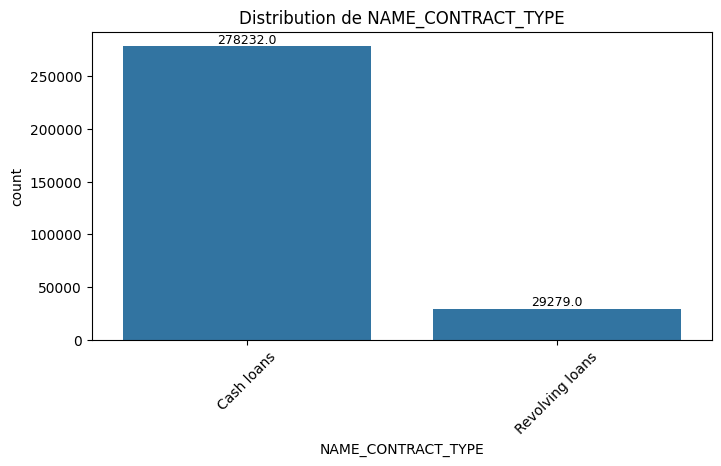

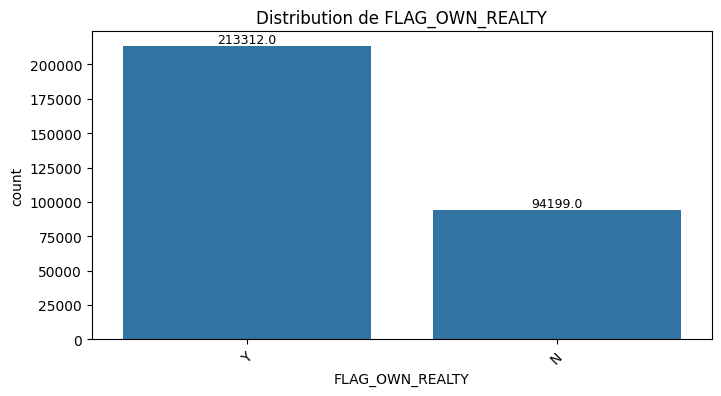

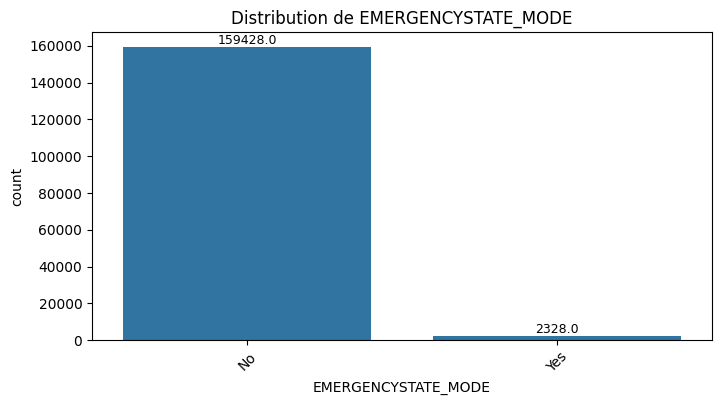

In [22]:
plot_categorical_distributions(df,categorical_summary(df)['Column'] )

### **Analyse des corrélations**

In [23]:
df.select_dtypes(include=np.number).corr()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000849,-0.001500,0.001366,...,0.000509,0.000167,0.001073,0.000282,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,...,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,-0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,-0.239818,...,0.004031,0.000864,0.000988,-0.002450,-0.000410,-0.000366,-0.002436,-0.010808,-0.007836,-0.041550
AMT_INCOME_TOTAL,-0.001820,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,-0.064223,...,0.003130,0.002408,0.000242,-0.000589,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690
AMT_CREDIT,-0.000343,-0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.066838,...,0.034329,0.021082,0.031023,-0.016148,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,-0.002193,0.002704,-0.000366,0.002944,0.004238,0.002185,0.004677,0.001399,0.002255,0.000472,...,0.013281,0.001126,-0.000120,-0.001130,0.230374,1.000000,0.217412,-0.005258,-0.004416,-0.003355
AMT_REQ_CREDIT_BUREAU_WEEK,0.002099,0.000788,-0.002436,0.002387,-0.001275,0.013881,-0.001007,-0.002149,-0.001336,0.003072,...,-0.004640,-0.001275,-0.001770,0.000081,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917
AMT_REQ_CREDIT_BUREAU_MON,0.000485,-0.012462,-0.010808,0.024700,0.054451,0.039148,0.056422,0.078607,0.001372,-0.034457,...,-0.001565,-0.002729,0.001285,-0.003612,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975
AMT_REQ_CREDIT_BUREAU_QRT,0.001025,-0.002022,-0.007836,0.004859,0.015925,0.010124,0.016432,-0.001279,-0.011799,0.015345,...,-0.005125,-0.001575,-0.001010,-0.002004,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208


In [24]:
strong_target_corr, strong_pairs = correlation_analysis(df, threshold=0.01)
#plot_correlation_matrix(train)

#### Variables corrélées à TARGET

In [32]:
print("correlation avec TARGET",strong_target_corr.shape)
strong_target_corr.head(10)

correlation avec TARGET (69,)


,TARGET
TARGET,1.000000
EXT_SOURCE_3,0.178919
EXT_SOURCE_2,0.160472
EXT_SOURCE_1,0.155317
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994


#### Corrélation entre variables

In [33]:
print("correlation entre variables",strong_pairs.shape)
strong_pairs.head(10)

correlation entre variables (6028,)


,,0
DAYS_EMPLOYED,FLAG_EMP_PHONE,0.999755
FLAG_EMP_PHONE,DAYS_EMPLOYED,0.999755
YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998495
YEARS_BUILD_MEDI,YEARS_BUILD_AVG,0.998495
OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998490
OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.998490
FLOORSMIN_MEDI,FLOORSMIN_AVG,0.997241
FLOORSMIN_AVG,FLOORSMIN_MEDI,0.997241
FLOORSMAX_AVG,FLOORSMAX_MEDI,0.997034
FLOORSMAX_MEDI,FLOORSMAX_AVG,0.997034


### **Valeurs manquantes**

In [34]:
null_rate= null_values_summary(df, percent=30)
print("nombre de colonnes avec des valeurs nulles:", null_rate.shape[0])
null_rate

nombre de colonnes avec des valeurs nulles: 50


,Total,Percent
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


**Taux de Valeurs nulles par ligne**

In [28]:
missing_by_row=missing_values_by_row(df,threshold=0)
missing_by_row

,Total_missing,Percent_missing
150206,61,50.000000
269786,61,50.000000
185713,61,50.000000
69707,61,50.000000
197736,61,50.000000
...,...,...
281823,1,0.819672
281854,1,0.819672
281840,1,0.819672
281856,1,0.819672


### **Détection des outliers**

In [29]:
(df['DAYS_BIRTH']//-365).head()

,DAYS_BIRTH
0,25
1,45
2,52
3,52
4,54


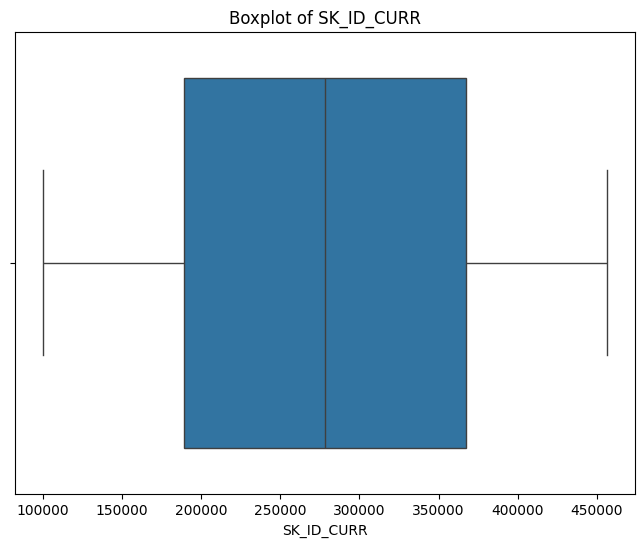

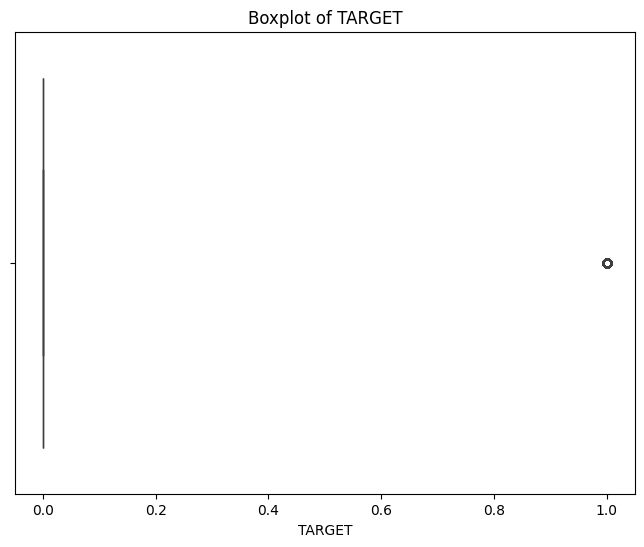

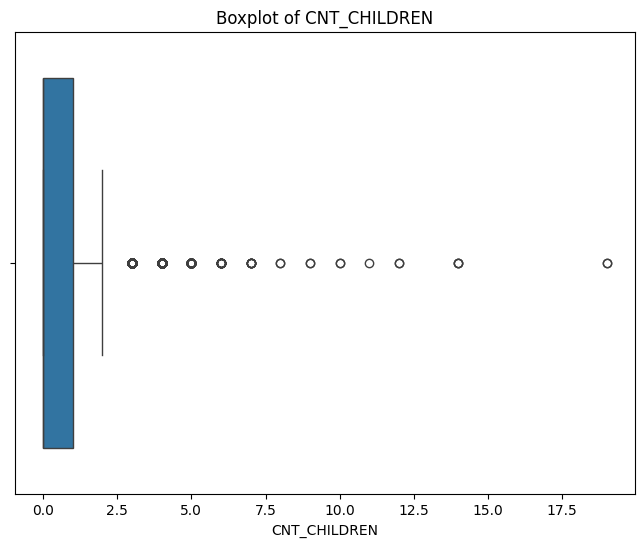

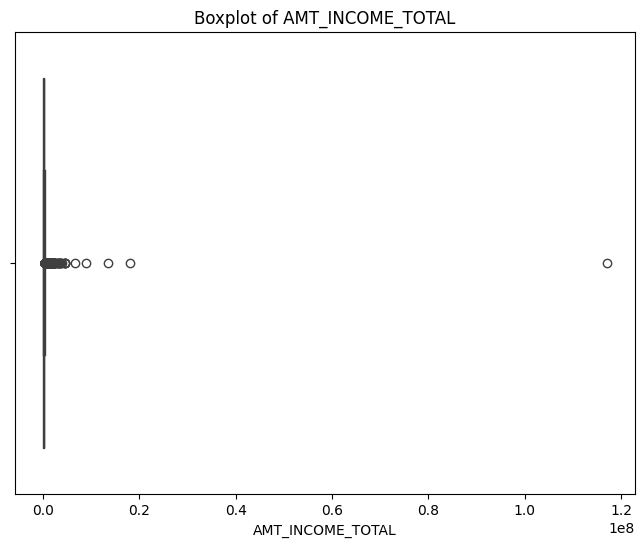

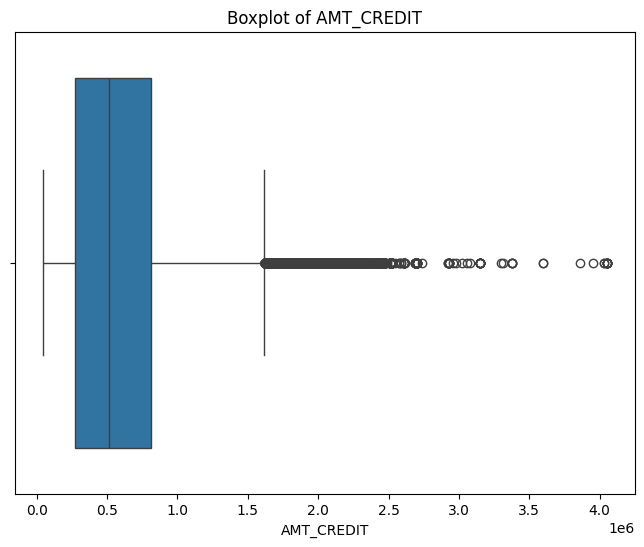

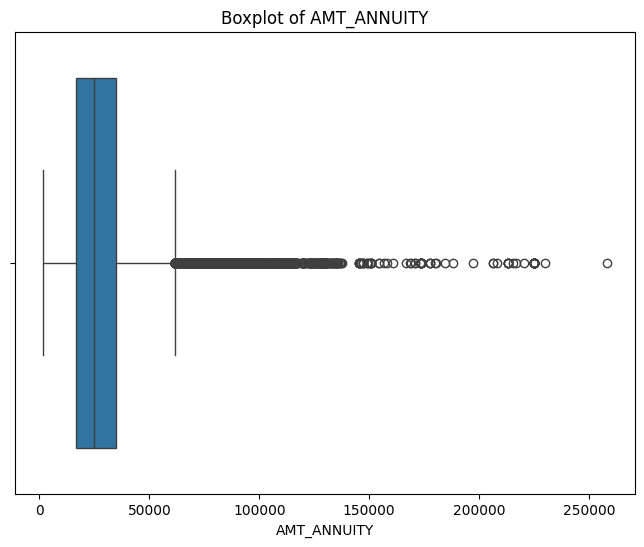

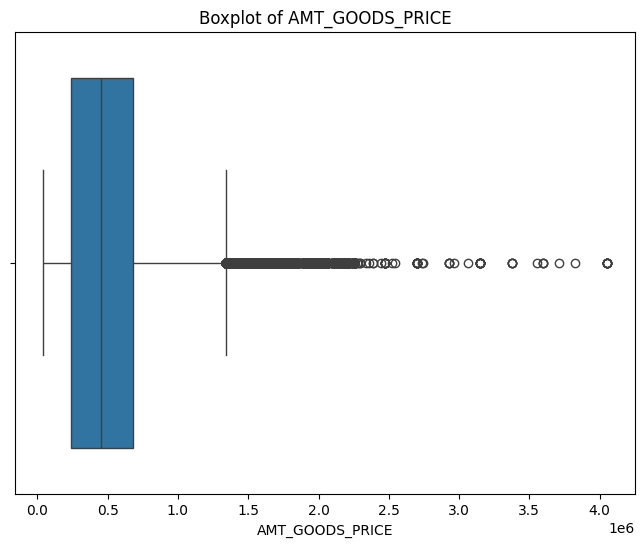

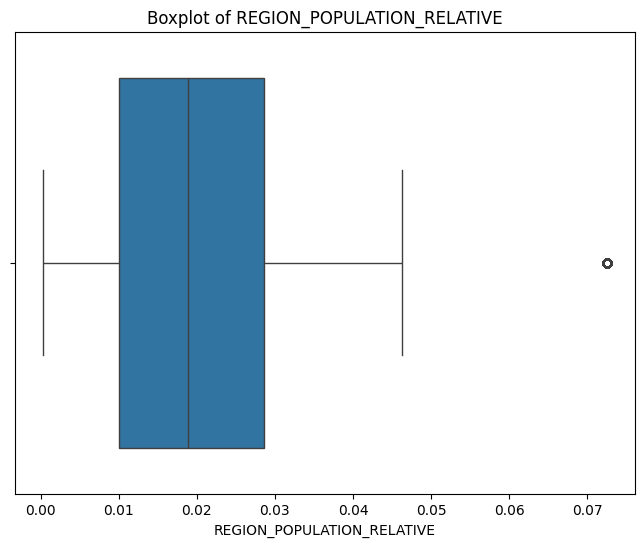

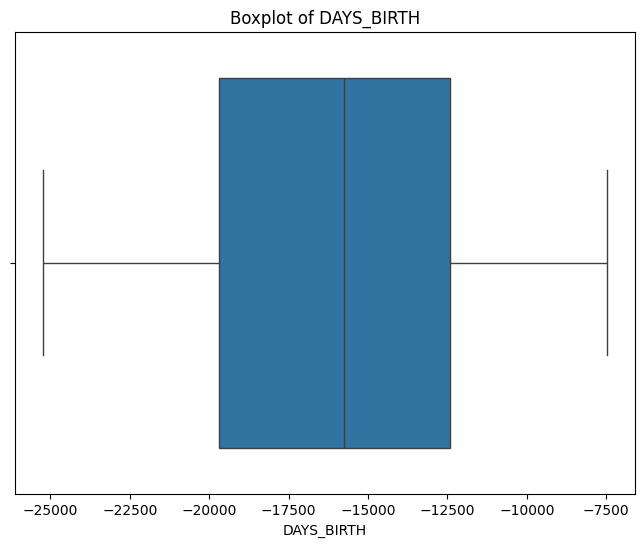

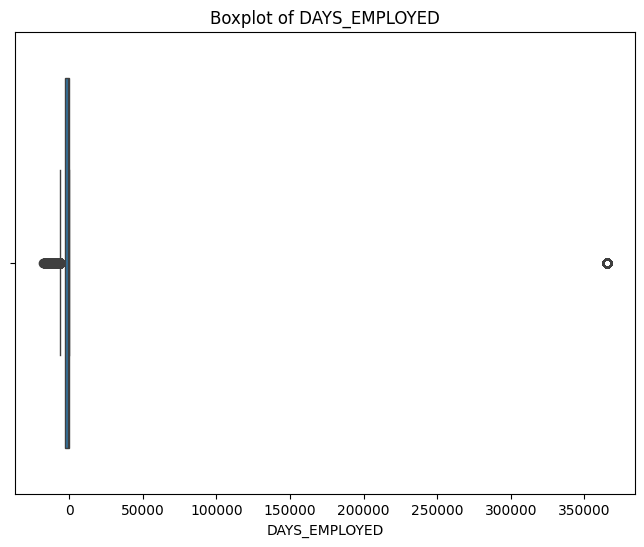

In [30]:
# Create boxplots for numerical features to detect outliers
numerical_features = df.select_dtypes(include=np.number).columns
for col in numerical_features[:10]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Préparation et traitement des données

In [ ]:
df = pd.read_csv('application_train.csv', sep=',')
df.shape

(307511, 122)

**Suppression de valeurs nulles**

suppression des lignes et des colonnes avec plus de 50% de valeurs nulles

In [ ]:
#Supprimer les lignes avec >= 50% de valeurs manquantes
missing_by_row = missing_values_by_row(df, threshold=0)
rows_to_drop = missing_by_row[missing_by_row['Percent_missing'] >= 50].index.tolist()
train = df.drop(index=rows_to_drop)
print(f"{len(rows_to_drop)} lignes supprimées.")

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
nullrate = null_values_summary(train)
cols_to_drop = nullrate[nullrate['Percent'] >= 50].index.tolist()
train = train.drop(columns=cols_to_drop)
print(f"{len(cols_to_drop)} colonnes supprimées")
print(train.shape)

9 lignes supprimées.
41 colonnes supprimées
(307502, 81)


**imputation par le mode pour les variables catégorielles**


In [ ]:
# Fonction d'imputation des variables catégorielles
def impute_categorical_by_mode(df):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

# #Imputation des variables numériques avec la médiane
# num_cols = train.select_dtypes(include=['int64', 'float64']).columns
# num_imputer = SimpleImputer(strategy='median')
# train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation des variables catégorielles
train = impute_categorical_by_mode(train)


In [ ]:
null_values_summary(train)

,Total,Percent
FLOORSMAX_AVG,153011,49.759351
FLOORSMAX_MEDI,153011,49.759351
FLOORSMAX_MODE,153011,49.759351
YEARS_BEGINEXPLUATATION_MEDI,149998,48.779520
YEARS_BEGINEXPLUATATION_MODE,149998,48.779520
YEARS_BEGINEXPLUATATION_AVG,149998,48.779520
TOTALAREA_MODE,148422,48.267003
EXT_SOURCE_3,60956,19.822961
AMT_REQ_CREDIT_BUREAU_YEAR,41510,13.499099
AMT_REQ_CREDIT_BUREAU_WEEK,41510,13.499099


**Encodage des variables categorielles**

In [ ]:
# Colonnes catégorielles
cat_cols = train.select_dtypes(include='object').columns

# Séparation selon la cardinalité
low_cardinality_cols = [col for col in cat_cols if train[col].nunique() <= 10]
high_cardinality_cols = [col for col in cat_cols if train[col].nunique() > 10]

# Encodage OneHot pour faible cardinalité
train = pd.get_dummies(train, columns=low_cardinality_cols, drop_first=True)

# Encodage par fréquence pour forte cardinalité
for col in high_cardinality_cols:
    freq_encoding = train[col].value_counts(normalize=True)
    train[col] = train[col].map(freq_encoding)


In [ ]:
train.shape

(307502, 109)

**Suppression de la colinéarité**


In [ ]:
#Réduction de la colinéarité
strong_target_corr, strong_pairs = correlation_analysis(train, threshold=0.01)

In [ ]:
# Corrélation avec la cible
target_corr = strong_target_corr['TARGET'] if isinstance(strong_target_corr, pd.DataFrame) else strong_target_corr

# Paires très corrélées entre elles
high_corr_pairs = strong_pairs[strong_pairs > 0.85]

# Colonnes à supprimer (celle la moins liée à TARGET dans chaque paire)
cols_to_remove = set()
for var1, var2 in high_corr_pairs.index:
    corr1 = target_corr.get(var1, 0)
    corr2 = target_corr.get(var2, 0)
    if corr1 < corr2:
        cols_to_remove.add(var1)
    else:
        cols_to_remove.add(var2)

print(f"{len(cols_to_remove)} colonnes supprimées (corrélation > 0.85)")
train = train.drop(columns=list(cols_to_remove))
print(train.shape)


14 colonnes supprimées (corrélation > 0.85)
(307502, 95)


# Séparation des données (Imputation, scaling, SMOTE)

In [ ]:
X = train.drop(columns='TARGET')
y = train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Imputation par la médiane (plus rapide que KNNImputer et moins sensible au outliers)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Avant : {Counter(y_train)}, Après : {Counter(y_train_smote)}")

Avant : Counter({0: 226141, 1: 19860}), Après : Counter({0: 226141, 1: 226141})


# Séparation des données (Imputation, scaling, PCA, SMOTE)

In [ ]:
X = train.drop(columns='TARGET')
y = train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# # Imputation par la médiane
# imputer = SimpleImputer(strategy='median')
# X_train_imputed = imputer.fit_transform(X_train)
# X_test_imputed = imputer.transform(X_test)

# # Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_imputed)
# X_test_scaled = scaler.transform(X_test_imputed)

# PCA : réduction à 95% de la variance expliquée
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA: Nombre de composantes retenues : {X_train_pca.shape[1]}")

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

print(f"SMOTE: Avant : {Counter(y_train)}, Après : {Counter(y_train_smote)}")

# Entraînement et évaluation du modèle LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 226141, number of negative: 226141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15065
[LightGBM] [Info] Number of data points in the train set: 452282, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy : 0.9187330287312402
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.42      0.02      0.03      4965

    accuracy                           0.92     61501
   macro avg       0.67      0.51      0.49     61501
weighted avg       0.88      0.92      0.88     61501



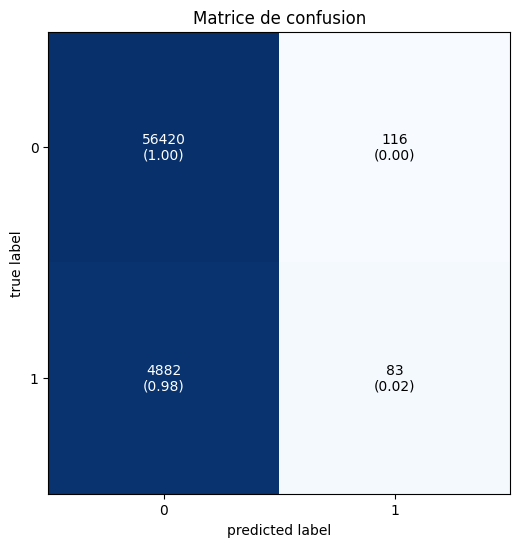

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Entraînement du modèle LightGBM
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_smote, y_train_smote)

# Prédiction
y_pred = lgb_model.predict(X_test_scaled)

# Évaluation
print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(6,6), show_absolute=True, show_normed=True)
plt.title("Matrice de confusion")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Seuil optimal pour LightGBM : 0.11
💰 Coût métier minimal : 34,363,000 €


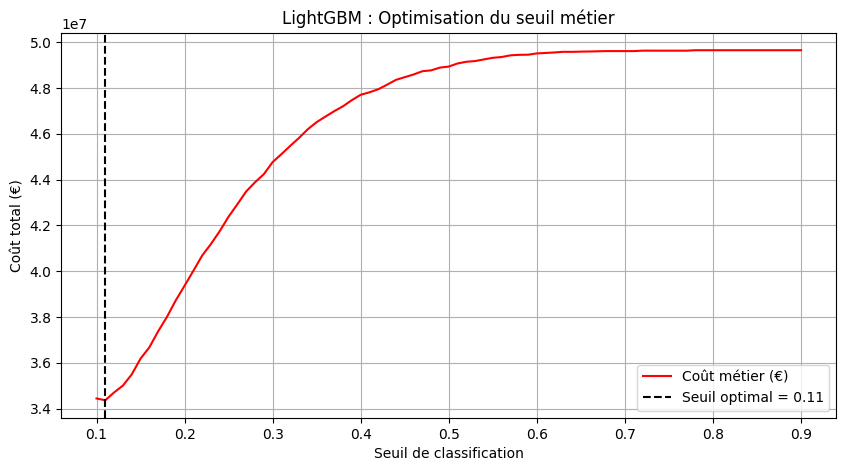

📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56536
           1       0.17      0.61      0.26      4965

    accuracy                           0.73     61501
   macro avg       0.56      0.67      0.55     61501
weighted avg       0.89      0.73      0.79     61501

AUC : 0.7371


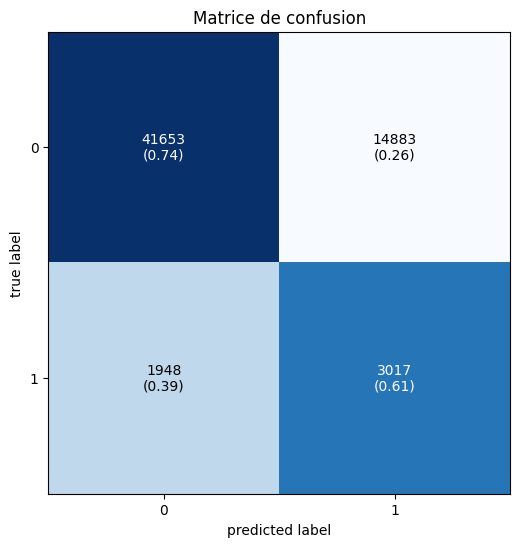

In [ ]:
# 2. Prédiction des probabilités
y_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

optimal_threshold_rf, final_cost_rf = evaluate_cost_based_threshold(
    y_true=y_test,
    y_proba=y_proba_lgb,
    C_FP=1000,
    C_FN=10000,
    model_name="LightGBM"
)

# Évaluation finale au seuil optimal
y_opt = (y_proba_lgb > optimal_threshold_rf).astype(int)
auc = roc_auc_score(y_test, y_proba_lgb)
print(f"AUC : {auc:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_opt)
plot_confusion_matrix(conf_mat=cm, figsize=(6,6), show_absolute=True, show_normed=True)
plt.title("Matrice de confusion")
plt.show()



# Entraînement et évaluation du modèle RandomForest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_smote, y_train_smote)
joblib.dump(scaler, "scaler.pkl")
joblib.dump(imputer, "imputer.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

['random_forest_model.pkl']

Accuracy : 0.9154160094957805
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56536
           1       0.28      0.03      0.05      4965

    accuracy                           0.92     61501
   macro avg       0.60      0.51      0.50     61501
weighted avg       0.87      0.92      0.88     61501



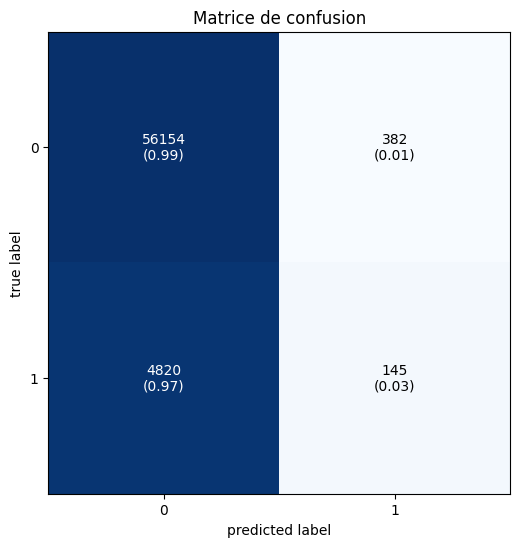

In [ ]:
# Prédiction
y_pred = rf_model.predict(X_test_scaled)

# Évaluation
print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(6,6), show_absolute=True, show_normed=True)
plt.title("Matrice de confusion")
plt.show()

✅ Seuil optimal pour RandomForest : 0.20
💰 Coût métier minimal : 35,857,000 €


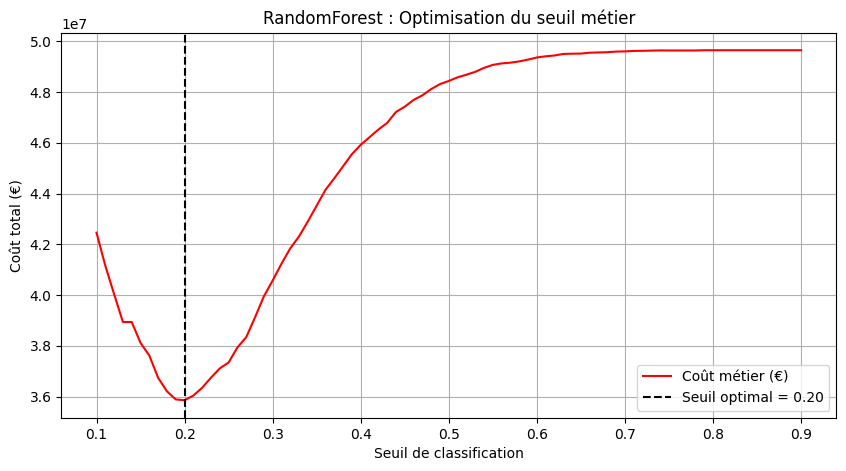

📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     56536
           1       0.16      0.61      0.25      4965

    accuracy                           0.70     61501
   macro avg       0.55      0.66      0.53     61501
weighted avg       0.89      0.70      0.77     61501

AUC : 0.7104


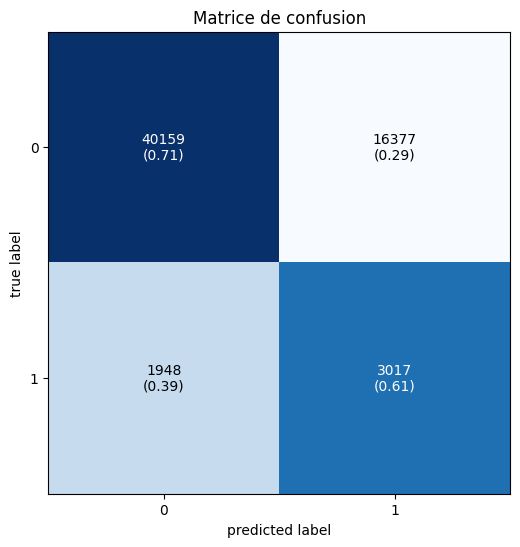

In [ ]:
#Évaluation avec fonction coût métier
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

optimal_threshold_rf, final_cost_rf = evaluate_cost_based_threshold(
    y_true=y_test,
    y_proba=y_proba_rf,
    C_FP=1000,
    C_FN=10000,
    model_name="RandomForest"
)

# Évaluation finale au seuil optimal
y_opt = (y_proba_rf > optimal_threshold_rf).astype(int)

auc = roc_auc_score(y_test, y_proba_rf)
print(f"AUC : {auc:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_opt)
plot_confusion_matrix(conf_mat=cm, figsize=(6,6), show_absolute=True, show_normed=True)
plt.title("Matrice de confusion")
plt.show()

# Optimisation du Random Forest

In [ ]:
!pip install --upgrade hyperopt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas


# Coût métier (ajustable)
def cost_function(y_true, y_pred, C_FP=1000, C_FN=10000):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0, 1]
    FN = cm[1, 0]
    return (FP * C_FP) + (FN * C_FN)


def objective(params):
    clf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    costs = []

    # Convert X_train_smote to DataFrame if it's not already
    if not isinstance(X_train_smote, pd.DataFrame):
        X_train_smote_df = pd.DataFrame(X_train_smote) #Convert to DataFrame
    else:
        X_train_smote_df = X_train_smote

    for train_idx, test_idx in skf.split(X_train_smote_df, y_train_smote):
        #Use .iloc on the DataFrame
        X_train_cv = X_train_smote_df.iloc[train_idx]
        y_train_cv = y_train_smote.iloc[train_idx]
        X_val_cv = X_train_smote_df.iloc[test_idx]
        y_val_cv = y_train_smote.iloc[test_idx]

        clf.fit(X_train_cv, y_train_cv)
        preds = clf.predict(X_val_cv)
        cost = cost_function(y_val_cv, preds)
        costs.append(cost)

    return {'loss': np.mean(costs), 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
}

In [ ]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    # Use a different random state generator
    rstate=np.random.default_rng(42)
)

print("🎯 Meilleurs hyperparamètres trouvés :", best)

# Entraînement et évaluation du modèle MLP


In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weight_dict = dict(enumerate(class_weights))
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_smote.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Recall(name='recall'), Precision(name='precision')]
)

# Early stopping
es = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')

# Entraînement
history = model.fit(
    X_train_smote, y_train_smote,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[es],
    verbose=1
)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weight_dict = dict(enumerate(class_weights))

model = Sequential([
    Dense(512, input_shape=(X_train_smote.shape[1],)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64),
    LeakyReLU(alpha=0.01),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Recall(name='recall'), Precision(name='precision')]
)

# Early stopping
es = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')

# Entraînement
history = model.fit(
    X_train_smote, y_train_smote,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[es],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 83s 13ms/step - accuracy: 0.7204 - auc: 0.7713 - loss: 0.5500 - precision: 0.6473 - recall: 0.5602 - val_accuracy: 0.7187 - val_auc: 0.0000e+00 - val_loss: 0.5816 - val_precision: 1.0000 - val_recall: 0.7187
Epoch 2/100
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - accuracy: 0.7679 - auc: 0.8319 - loss: 0.4842 - precision: 0.7180 - recall: 0.6262 - val_accuracy: 0.6862 - val_auc: 0.0000e+00 - val_loss: 0.6011 - val_precision: 1.0000 - val_recall: 0.6862
Epoch 3/100
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - accuracy: 0.7829 - auc: 0.8502 - loss: 0.4598 - precision: 0.7427 - recall: 0.6432 - val_accuracy: 0.7661 - val_auc: 0.0000e+00 - val_loss: 0.5061 - val_precision: 1.0000 - val_recall: 0.7661
Epoch 4/100
5654/5654 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.7942 - auc: 0.8622 - loss: 0.4419 - precision: 0.7514 - recall: 0.6711 - val_accuracy: 0.4624 - val_auc: 0.0000e+00 - val_loss: 0.8000 - val_precision: 1.0000 - val_recall: 0.4

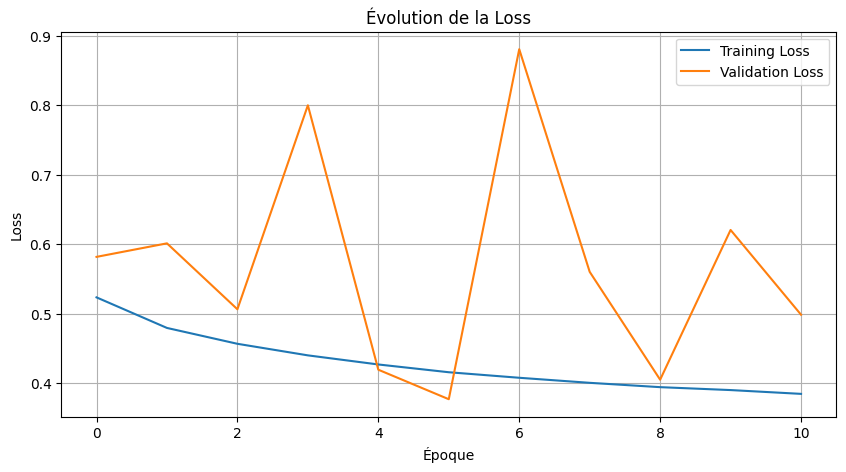

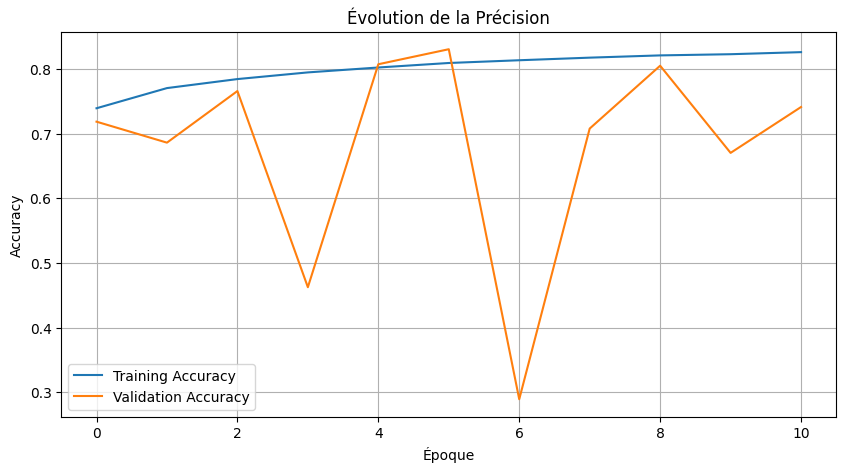

In [ ]:
courbes_validation(history)

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Évaluation MLP (seuil 0.5)
Accuracy : 0.810529567663366
Matrice de confusion :
 [[47857  8681]
 [ 2972  1993]]


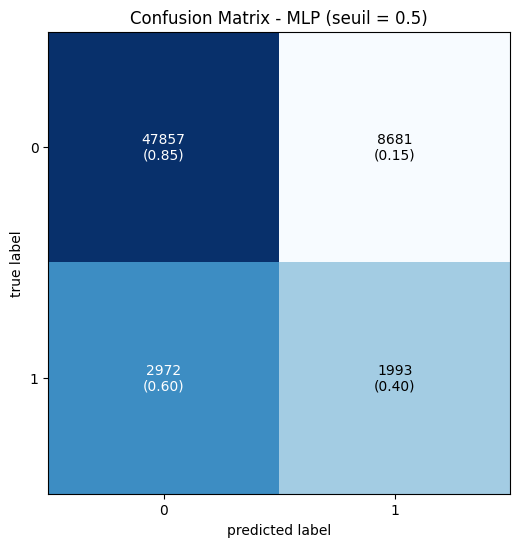

In [ ]:
y_proba_mlp = model.predict(X_test_scaled).flatten()

y_pred_mlp = (y_proba_mlp > 0.5).astype(int)

print("Évaluation MLP (seuil 0.5)")
print("Accuracy :", accuracy_score(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
print("Matrice de confusion :\n", cm)

#Affichage de la matrice
plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), show_absolute=True, show_normed=True)
plt.title("Confusion Matrix - MLP (seuil = 0.5)")
plt.show()


✅ Seuil optimal pour MLP : 0.34
💰 Coût métier minimal : 35,806,000 €


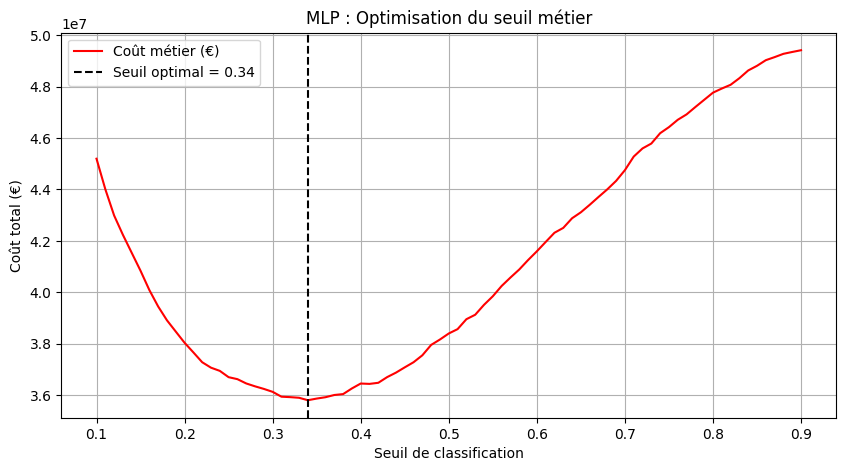

📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      0.50      0.66     56538
           1       0.12      0.81      0.21      4965

    accuracy                           0.52     61503
   macro avg       0.55      0.65      0.44     61503
weighted avg       0.90      0.52      0.62     61503



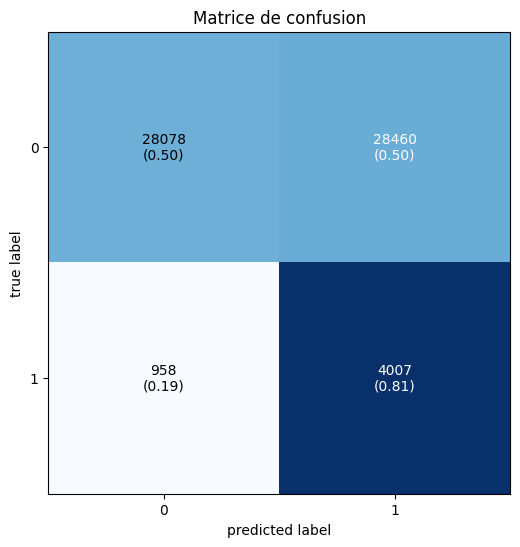

In [ ]:
# 💸 Évaluation coût métier optimisé
optimal_threshold_mlp, final_cost_mlp = evaluate_cost_based_threshold(
    y_true=y_test,
    y_proba=y_proba_mlp,
    C_FP=1000,
    C_FN=10000,
    model_name="MLP"
)
y_opt = (y_proba_mlp > optimal_threshold_rf).astype(int)
cm_opt = confusion_matrix(y_test, y_opt)
print("📊 Rapport de classification :")
print(classification_report(y_test, y_opt))

# Matrice de confusion
cm = confusion_matrix(y_test, y_opt)
plot_confusion_matrix(conf_mat=cm, figsize=(6,6), show_absolute=True, show_normed=True)
plt.title("Matrice de confusion")
plt.show()

#  Entraînement et évaluation du modèle XGBoost

In [ ]:
import xgboost as xgb

counter = Counter(y_train_smote)
scale_pos_weight = counter[0] / counter[1]  # classe majoritaire / classe minoritaire

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:09:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Évaluation XGBoost (seuil = 0.5)
Accuracy: 0.9189633026031251
Matrice de confusion :
 [[56445    93]
 [ 4891    74]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.44      0.01      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



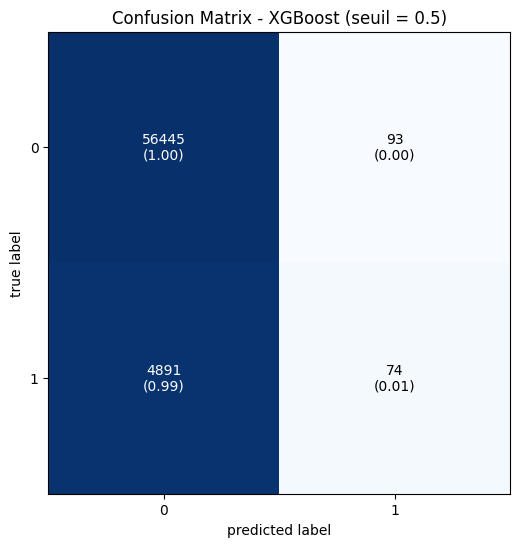

In [ ]:
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Seuil 0.5
y_pred_xgb = (y_proba_xgb > 0.5).astype(int)

print("Évaluation XGBoost (seuil = 0.5)")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Matrice de confusion visuelle
plot_confusion_matrix(
    conf_mat=confusion_matrix(y_test, y_pred_xgb),
    figsize=(6, 6),
    show_absolute=True,
    show_normed=True
)
plt.title("Confusion Matrix - XGBoost (seuil = 0.5)")
plt.show()


✅ Seuil optimal pour XGBoost : 0.12
💰 Coût métier minimal : 34,570,000 €


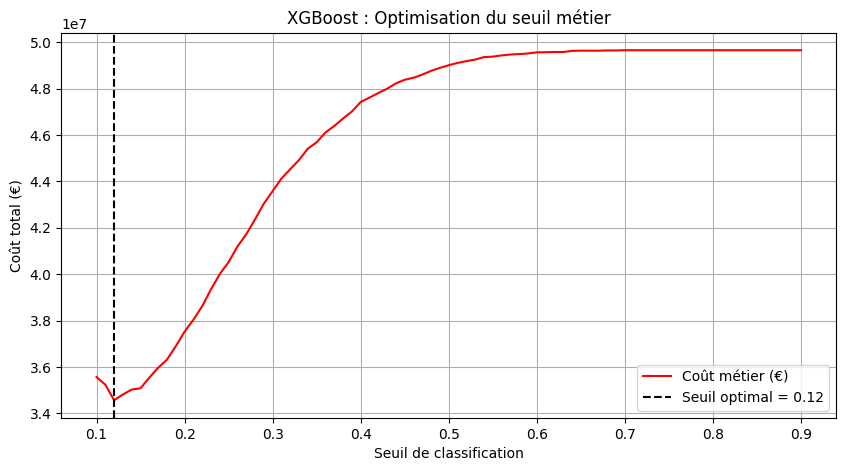

Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     56538
           1       0.21      0.39      0.27      4965

    accuracy                           0.83     61503
   macro avg       0.58      0.63      0.59     61503
weighted avg       0.88      0.83      0.86     61503



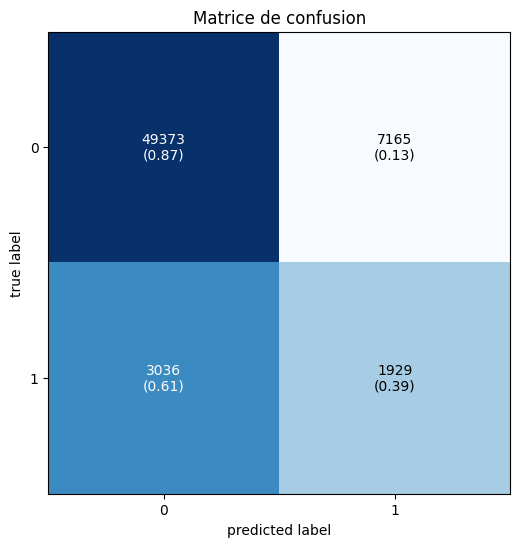

In [ ]:
# Évaluation du seuil métier optimal
optimal_threshold_xgb, final_cost_xgb = evaluate_cost_based_threshold(
    y_true=y_test,
    y_proba=y_proba_xgb,
    C_FP=1000,
    C_FN=10000,
    model_name="XGBoost"
)
y_opt = (y_proba_xgb > optimal_threshold_rf).astype(int)
cm_opt = confusion_matrix(y_test, y_opt)
print("Rapport de classification :")
print(classification_report(y_test, y_opt))

# Matrice de confusion
cm = confusion_matrix(y_test, y_opt)
plot_confusion_matrix(conf_mat=cm, figsize=(6,6), show_absolute=True, show_normed=True)
plt.title("Matrice de confusion")
plt.show()

# Sauvegarde des modèles

In [ ]:

# Sauvegarde des objets de prétraitement
joblib.dump(scaler, "scaler.h5")
joblib.dump(imputer, "imputer.h5")

#Random Forest
joblib.dump(rf_model, "random_forest_model.h5")
# XGBoost
joblib.dump(xgb_model, "xgboost_model.pkl")
# MLP
model.save("mlp_model.h5")
print("Sauvegarde terminée'")


# Interpretabilité

In [ ]:
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)


In [ ]:
# Importance des variables
shap.summary_plot(shap_values, X_test)

In [ ]:
# Summary plot du label 1
shap.summary_plot(shap_values[0], X_test)

In [ ]:
# Choisir un échantillon individuel (ex: le 10e)
index = 10
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][index], X_train_smote.iloc[index])